### instead of generating random samples, we can add a condition to our generation. For this we input the label infromation as well in the images.First, we pass fake images and fake labels to our generation to generate something. Then to the discriminator, at one time we pass the real images and real labels, and next time we pass fake images and fake labels from the generator and ask it to predict true and fake. The labels instead of passing as sparse vector , their embeddings are passed.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*SXRW2IxUeDxpPj7j.png" width="700" height="500">

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
class MNISTConditionalGenerator(nn.Module):

  def __init__(self,latent_dim=100, embedding_dim=16,num_classes=10):
    super().__init__()

    self.embeddings = nn.Embedding(num_classes,embedding_dim)

    self.generator = nn.Sequential(
        nn.Linear(latent_dim+embedding_dim,256),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,512),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 784),
        nn.Tanh()
    )

  def forward(self,noise,labels):
    batch_size = noise.shape[0]

    embeddings = self.embeddings(labels)

    concat = torch.cat([noise,embeddings],dim=-1)
    generated_data  = self.generator(concat)
    generated_data=generated_data.reshape(batch_size,1,28,28)
    return generated_data


class MNISTConditionalDiscriminator(nn.Module):

  def __init__(self,embedding_dim=16,num_classes=10):
    super().__init__()

    self.embeddings = nn.Embedding(num_classes,embedding_dim)

    self.discriminator = nn.Sequential(
        nn.Linear(784+embedding_dim,512),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(512,256),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,1)
    )

  def forward(self,data,labels):

    batch_size = data.shape[0]
    data = data.reshape(-1,28*28)

    embeddings = self.embeddings(labels)

    concat = torch.cat([data,embeddings],dim=-1)
    out = self.discriminator(concat)
    return out



In [3]:

latent_dim =100
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 200

generator = MNISTConditionalGenerator(latent_dim).to(device)
discriminator = MNISTConditionalDiscriminator().to(device)

In [4]:

generator_optimizer = torch.optim.Adam(generator.parameters(), lr= 0.001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr= 0.001)

In [5]:
transform= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True,
                                           )

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform,
                                          download = True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False,drop_last=True)



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.93MB/s]


In [8]:
### training step
def train_gan(generator,
              discriminator,
              generator_optimizer,
              discriminator_optimizer,
              plot_loss_freq,
              plt_eval_freq,
              epochs,
              trainloader,
              testloader,
              latent_dim= latent_dim,
              device = device,
              num_classes=10,
              ):

  loss_funct = nn.BCEWithLogitsLoss()

  discriminator_loss = []
  generator_loss = []

  for epoch in tqdm(range(epochs)):
    discriminator_epoch_loss = []
    generator_epoch_loss = []

    for real_images, _ in trainloader:

      real_images = real_images.to(device)
      real_digits_labels = _.to(device)

      batch_size = real_images.shape[0]

      # generate noise and fake labels for generator
      noise = torch.randn(batch_size,latent_dim,device=device)
      raw_digits_labels = torch.randint(0,num_classes,size=(batch_size,),device=device)

      # labels for discriminator
      true_labels = torch.ones(batch_size,1, device=device)
      fake_labels = torch.zeros(batch_size,1,device=device)

      # generating data
      fake_images = generator(noise,raw_digits_labels).detach()

      # predictiion by discriminator
      real_preds = discriminator(real_images,real_digits_labels)
      fake_preds = discriminator(fake_images,raw_digits_labels)


      # loss
      real_loss = loss_funct(real_preds,true_labels)
      fake_loss = loss_funct(fake_preds,fake_labels)

      discriminator_loss_epoch = (real_loss + fake_loss)/2

      discriminator_epoch_loss.append(discriminator_loss_epoch.item())

      # update
      discriminator_optimizer.zero_grad()
      discriminator_loss_epoch.backward()
      discriminator_optimizer.step()


      ### generator training ###

      noise = torch.randn(batch_size,latent_dim,device=device)
      raw_digits_labels = torch.randint(0,num_classes,size=(batch_size,),device=device)

      generated_data = generator(noise,raw_digits_labels)

      gen_discriminator_pred = discriminator(generated_data,raw_digits_labels)

      # loss

      generator_loss_epoch = loss_funct(gen_discriminator_pred,true_labels)
      generator_epoch_loss.append(generator_loss_epoch.item())


      #update
      generator_optimizer.zero_grad()
      generator_loss_epoch.backward()
      generator_optimizer.step()

    dis_epoch_loss = torch.mean(torch.tensor(discriminator_epoch_loss))
    gen_epoch_loss = torch.mean(torch.tensor(generator_epoch_loss))

    discriminator_loss.append(dis_epoch_loss.item())
    generator_loss.append(gen_epoch_loss.item())


    ##logging
    if epoch % plot_loss_freq ==0:
      print(f"epoch : {epoch}/{epochs} | Generator_loss : {gen_epoch_loss.item()} | Discriminator_loss : {dis_epoch_loss.item()}")


    #plot generated samples
    if epoch % plt_eval_freq ==0:
      generator.eval()

      with torch.no_grad():
          noise = torch.randn(10, latent_dim,device=device)
          raw_digits_labels = torch.arange(num_classes,device=device)
          generated_images = generator(noise,raw_digits_labels)
          generated_images = generated_images.cpu()

          fig, ax = plt.subplots(1, 10, figsize=(10, 8))

          for i in range(10):
            images = (generated_images[i].squeeze() + 1)/2 # scaling from -1 to 1 to 0-1
            ax[i].imshow(images.numpy(),cmap='gray')
            ax[i].set_axis_off()

          plt.show()


      generator.train()

  return discriminator, generator, discriminator_loss, generator_loss

  0%|          | 0/250 [00:00<?, ?it/s]

epoch : 0/250 | Generator_loss : 3.4999051094055176 | Discriminator_loss : 0.23380281031131744


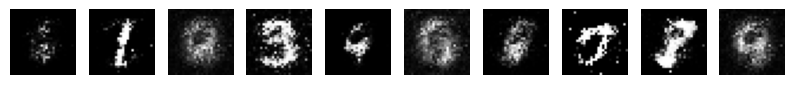

 20%|██        | 50/250 [14:49<1:00:05, 18.03s/it]

epoch : 50/250 | Generator_loss : 1.0696914196014404 | Discriminator_loss : 0.5847176313400269


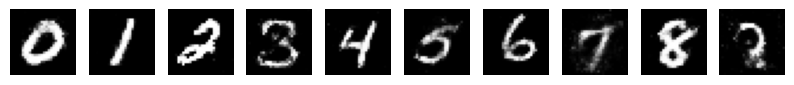

 40%|████      | 100/250 [29:22<43:43, 17.49s/it]

epoch : 100/250 | Generator_loss : 1.1009421348571777 | Discriminator_loss : 0.5742692351341248


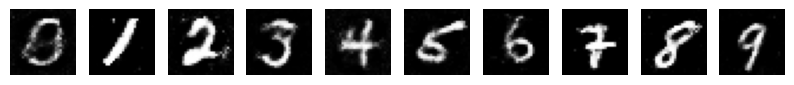

 60%|██████    | 150/250 [43:52<28:45, 17.25s/it]

epoch : 150/250 | Generator_loss : 1.241112470626831 | Discriminator_loss : 0.5368531346321106


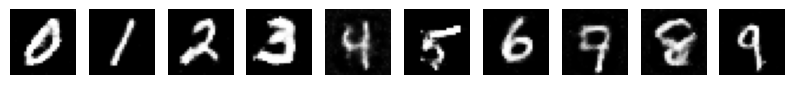

 80%|████████  | 200/250 [58:02<14:14, 17.09s/it]

epoch : 200/250 | Generator_loss : 1.3683130741119385 | Discriminator_loss : 0.50481116771698


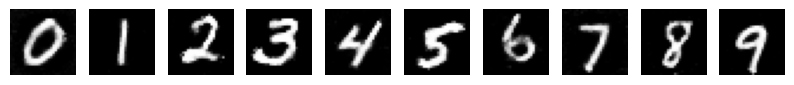

100%|██████████| 250/250 [1:12:01<00:00, 17.28s/it]


In [9]:
generator, discriminator, generator_loss, discriminator_loss = train_gan (
          generator,
          discriminator,
          generator_optimizer,
          discriminator_optimizer,
          50,
          50,
          250,
          train_loader,
          test_loader,
          latent_dim,
          device
)

### with conditional GANs, the problem of mode collapse seen in vanilla GAN is also removed, because now the generator network cannot just output same sample/distribution of data all the time, the generation has to be based on the condition.